<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preliminaries</a></span><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Notebook-Configuration" data-toc-modified-id="Notebook-Configuration-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Notebook Configuration</a></span></li></ul></li><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Processing</a></span><ul class="toc-item"><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Data-Separation---Train-and-Test" data-toc-modified-id="Data-Separation---Train-and-Test-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data Separation - Train and Test</a></span></li></ul></li><li><span><a href="#Classification-Models" data-toc-modified-id="Classification-Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Classification Models</a></span><ul class="toc-item"><li><span><a href="#Neural-Network" data-toc-modified-id="Neural-Network-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Neural Network</a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Logistic Regression</a></span></li></ul></li><li><span><a href="#Model-Comparison" data-toc-modified-id="Model-Comparison-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model Comparison</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Classification Problem - FIFA 17
In this notebook we will predict a players position based on its FIFA 17 stats. We will compare the results of a traditional Logistic Regresion with a relatively simple Neural Network.

## Preliminaries

### Libraries
For this notebook we will use sklearn for the logistic regression and tensorflow to create our Neural Network.

In [1]:
# Data Science
import pandas as pd
import numpy as np

# Machine Learning
import statsmodels.api as sm
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, multilabel_confusion_matrix

# Neural Networks
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.client import device_lib

# Visualización
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Notebook Configuration
I have enabled the option to use my GPU for the NN (even though it is a really simple NN and it is not necessary).

In [2]:
# Notebook Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Available Devices (CPUs, GPUs)
local_device_protos = device_lib.list_local_devices()
print([x.name for x in local_device_protos])

['/device:CPU:0', '/device:GPU:0']


## Data Processing
In this sections we will select the most relevant features.

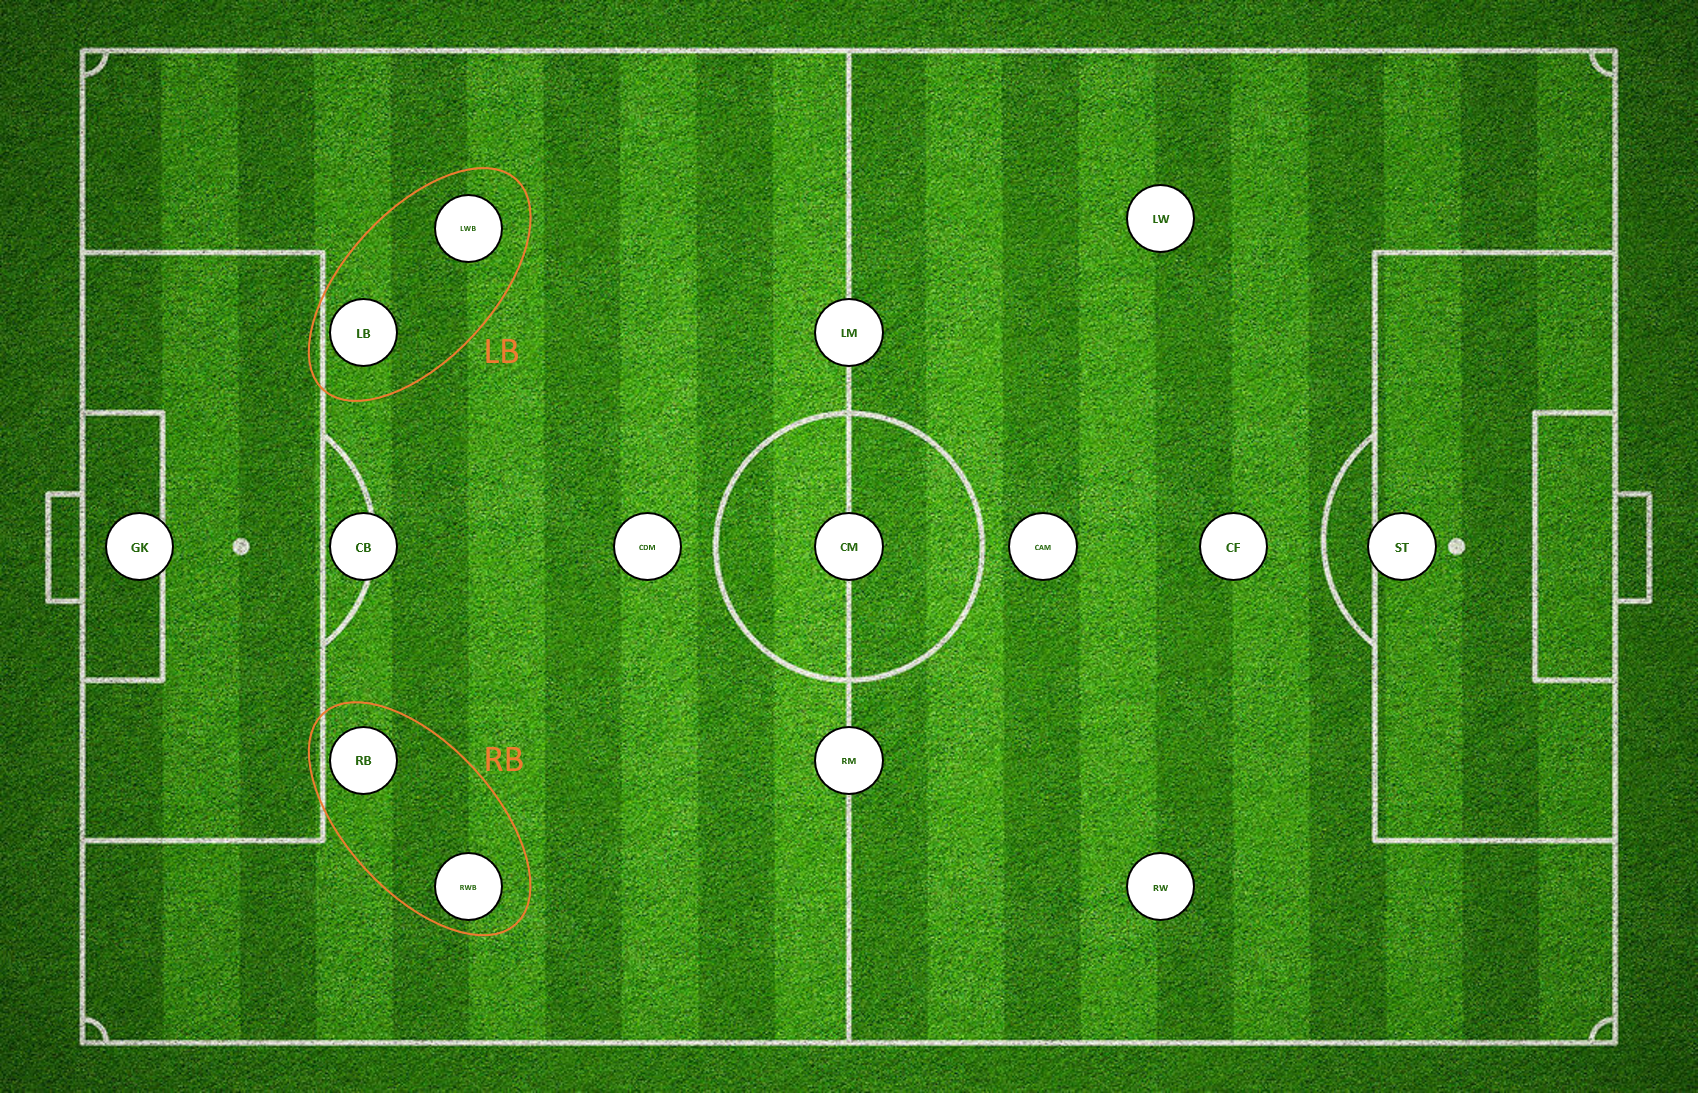

In [3]:
# FIFA 17 Player Positions
Image("Images/FIFA_player_positions.png")

We merge RB with RWB and LB with LWB, as both couples are very similar. This will reduce de classifitacion to 13 posible outcomes shown in the image above. Later on we will try to merge CF either with ST or CAM to see if we can get better results.

### Data Cleaning

In [4]:
# Import de Data
dataset  = pd.read_csv("FUT17.csv")

# Drop Columns
columns_drop = ["commonName",
                "headshotImgUrl",
                "league",
                "nation",
                "club", 
                "headshot", 
                "specialImages",
                "playStyleId",
                "playStyleId", 
                "birthdate",
                "updated_at", 
                "created_at", 
                "baseId",
                "traits",
                "specialities", 
                "playerType", 
                "fifaAttributes",
                "name",
                "quality",
                "color",
                "isGK",
                "positionFull",
                "isSpecialType", 
                "contracts",
                "fitness",
                "isLoan", 
                "squadPosition", 
                "itemType", 
                "discardValue", 
                "modelName",
                "rawAttributeChemistryBonus", 
                "playStyle", 
                "age"]

dataset = dataset.drop(columns=columns_drop)

# Select columns other than ID or Names
dataset_model = dataset.iloc[:,3:]

# Replace some feature values
change_names = {"RWB":"RB",
                "LWB":"LB",
                "CF":"ST",
                "Right":1,
                "Left":0,
                "High":3,
                "Medium":2,
                "Low":1,
               }

# Fix Positions
dataset_model = dataset_model.replace({"foot": change_names,
                                       "position": change_names,
                                       "atkWorkRate": change_names,
                                       "defWorkRate": change_names})

print("The shape of the datase is: ", dataset_model.shape)
dataset_model.head(3)

The shape of the datase is:  (14501, 43)


position  height  weight  acceleration  aggression  agility  balance  \
0       ST     174      70            95          55       94       94   
1       LW     185      80            91          63       90       63   
2       RW     170      72            92          48       90       95   

   ballcontrol foot  skillMoves  crossing  curve  dribbling  finishing  \
0           94    1           5        87     81         93         91   
1           92    1           5        84     81         93         93   
2           95    0           4        77     89         97         95   

   freekickaccuracy  gkdiving  gkhandling  gkkicking  gkpositioning  \
0                86        15          12         15             13   
1                77         7          11         15             14   
2                90         6          11         15             14   

   gkreflexes  headingaccuracy  interceptions  jumping  longpassing  \
0           6               83             61       86           85   
1          11               87             29       95           72   
2           8               71             22       68           87   

   longshots  marking  penalties  positioning  potential  reactions  \
0         87       48         88           96         95         96   
1         92       22         85           94         94         96   
2         88       13         74           93         93         95   

   shortpassing  shotpower  slidingtackle  sprintspeed  standingtackle  \
0            89         84             42           95              46   
1            82         94             23           92              31   
2            88         83             26           87              28   

   stamina  strength  vision  volleys  weakFoot  atkWorkRate  defWorkRate  \
0       88        71      96       90         4            3            1   
1       92        80      85       88         4            3            1   
2       74        59      90       85         4            2            2   

   rating  
0      95  
1      94  
2      93

### Data Separation - Train and Test

In [5]:
# Divide the data in predictors and objective
y = dataset_model["position"]
X = dataset_model.iloc[:,1:]

In [6]:
# Standardize Values
sc = StandardScaler()
X = sc.fit_transform(X)

In [7]:
# Train y Test Separation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 2504)

## Classification Models

### Neural Network
We construct a simple NN. 2 Hidden layers with droputs, each with 75 neurons.

In [8]:
classifier = Sequential()

# First Hidden Layer
classifier.add(Dense(75, activation='relu', kernel_initializer='random_normal', input_dim=42))

# Dropout
classifier.add(Dropout(0.4))

# Second Hidden Layer
classifier.add(Dense(75, activation='relu', kernel_initializer='random_normal'))

# Dropout
classifier.add(Dropout(0.4))

#Output Layer
classifier.add(Dense(12, activation='softmax', kernel_initializer='random_normal'))

In [9]:
#Compiling the neural network
tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
classifier.compile(optimizer ='Adam', loss='categorical_crossentropy', metrics =['accuracy'])

In [10]:
#Fitting the data to the training dataset
classifier.fit(X_train,pd.get_dummies(y_train).values, batch_size=32, epochs=500)

Train on 10150 samples
Epoch 1/500
10150/10150 [==============================] - 1s 95us/sample - loss: 1.3296 - accuracy: 0.5565
Epoch 2/500
10150/10150 [==============================] - 0s 43us/sample - loss: 0.8941 - accuracy: 0.6847
Epoch 3/500
10150/10150 [==============================] - 0s 45us/sample - loss: 0.8191 - accuracy: 0.7126
Epoch 4/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.7891 - accuracy: 0.7218
Epoch 5/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.7682 - accuracy: 0.7277
Epoch 6/500
10150/10150 [==============================] - 0s 45us/sample - loss: 0.7586 - accuracy: 0.7308
Epoch 7/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.7412 - accuracy: 0.7379
Epoch 8/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.7369 - accuracy: 0.7388
Epoch 9/500
10150/10150 [==============================] - 0s 45us/sample - loss: 0.7276 - accuracy: 0.7459
Epoch

10150/10150 [==============================] - 0s 46us/sample - loss: 0.5978 - accuracy: 0.7810
Epoch 77/500
10150/10150 [==============================] - 0s 45us/sample - loss: 0.5915 - accuracy: 0.7818
Epoch 78/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.5856 - accuracy: 0.7852
Epoch 79/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.5997 - accuracy: 0.7809
Epoch 80/500
10150/10150 [==============================] - 0s 44us/sample - loss: 0.5889 - accuracy: 0.7857
Epoch 81/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.5841 - accuracy: 0.7865
Epoch 82/500
10150/10150 [==============================] - 0s 45us/sample - loss: 0.5871 - accuracy: 0.7807
Epoch 83/500
10150/10150 [==============================] - 0s 45us/sample - loss: 0.5921 - accuracy: 0.7817
Epoch 84/500
10150/10150 [==============================] - 0s 44us/sample - loss: 0.5893 - accuracy: 0.7841
Epoch 85/500
10150/10150 [======

10150/10150 [==============================] - 0s 46us/sample - loss: 0.5489 - accuracy: 0.7980
Epoch 151/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.5492 - accuracy: 0.7953
Epoch 152/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.5509 - accuracy: 0.7944
Epoch 153/500
10150/10150 [==============================] - 0s 49us/sample - loss: 0.5489 - accuracy: 0.7981
Epoch 154/500
10150/10150 [==============================] - 0s 47us/sample - loss: 0.5410 - accuracy: 0.7990
Epoch 155/500
10150/10150 [==============================] - 1s 49us/sample - loss: 0.5466 - accuracy: 0.7993
Epoch 156/500
10150/10150 [==============================] - 0s 49us/sample - loss: 0.5512 - accuracy: 0.7973
Epoch 157/500
10150/10150 [==============================] - 0s 48us/sample - loss: 0.5558 - accuracy: 0.7936
Epoch 158/500
10150/10150 [==============================] - 0s 47us/sample - loss: 0.5430 - accuracy: 0.7956
Epoch 159/500
10150/1015

10150/10150 [==============================] - 0s 45us/sample - loss: 0.5418 - accuracy: 0.8033
Epoch 225/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.5355 - accuracy: 0.8009
Epoch 226/500
10150/10150 [==============================] - 0s 47us/sample - loss: 0.5249 - accuracy: 0.8052
Epoch 227/500
10150/10150 [==============================] - 1s 50us/sample - loss: 0.5265 - accuracy: 0.8055
Epoch 228/500
10150/10150 [==============================] - 0s 49us/sample - loss: 0.5303 - accuracy: 0.8073
Epoch 229/500
10150/10150 [==============================] - 1s 51us/sample - loss: 0.5259 - accuracy: 0.8057
Epoch 230/500
10150/10150 [==============================] - 1s 51us/sample - loss: 0.5279 - accuracy: 0.8052
Epoch 231/500
10150/10150 [==============================] - 0s 48us/sample - loss: 0.5276 - accuracy: 0.8043
Epoch 232/500
10150/10150 [==============================] - 0s 47us/sample - loss: 0.5208 - accuracy: 0.8052
Epoch 233/500
10150/1015

10150/10150 [==============================] - 0s 46us/sample - loss: 0.5053 - accuracy: 0.8091
Epoch 299/500
10150/10150 [==============================] - 0s 45us/sample - loss: 0.5092 - accuracy: 0.8058
Epoch 300/500
10150/10150 [==============================] - 0s 49us/sample - loss: 0.5104 - accuracy: 0.8127
Epoch 301/500
10150/10150 [==============================] - 0s 47us/sample - loss: 0.5131 - accuracy: 0.8089
Epoch 302/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.5171 - accuracy: 0.8094
Epoch 303/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.5098 - accuracy: 0.8121
Epoch 304/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.5178 - accuracy: 0.8091
Epoch 305/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.5087 - accuracy: 0.8134
Epoch 306/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.5196 - accuracy: 0.8077
Epoch 307/500
10150/1015

10150/10150 [==============================] - 0s 45us/sample - loss: 0.5048 - accuracy: 0.8113
Epoch 373/500
10150/10150 [==============================] - 0s 45us/sample - loss: 0.5001 - accuracy: 0.8142
Epoch 374/500
10150/10150 [==============================] - 1s 50us/sample - loss: 0.5101 - accuracy: 0.8076
Epoch 375/500
10150/10150 [==============================] - 1s 50us/sample - loss: 0.5014 - accuracy: 0.8129
Epoch 376/500
10150/10150 [==============================] - 1s 53us/sample - loss: 0.5053 - accuracy: 0.8104
Epoch 377/500
10150/10150 [==============================] - 1s 52us/sample - loss: 0.5007 - accuracy: 0.8125
Epoch 378/500
10150/10150 [==============================] - 1s 51us/sample - loss: 0.4987 - accuracy: 0.8128
Epoch 379/500
10150/10150 [==============================] - 0s 49us/sample - loss: 0.5117 - accuracy: 0.8092
Epoch 380/500
10150/10150 [==============================] - 1s 50us/sample - loss: 0.4934 - accuracy: 0.8133
Epoch 381/500
10150/1015

10150/10150 [==============================] - 0s 46us/sample - loss: 0.4948 - accuracy: 0.8150
Epoch 447/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.4862 - accuracy: 0.8167
Epoch 448/500
10150/10150 [==============================] - 0s 44us/sample - loss: 0.4950 - accuracy: 0.8142
Epoch 449/500
10150/10150 [==============================] - 0s 45us/sample - loss: 0.5018 - accuracy: 0.8139
Epoch 450/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.4895 - accuracy: 0.8171
Epoch 451/500
10150/10150 [==============================] - 0s 47us/sample - loss: 0.5014 - accuracy: 0.8124
Epoch 452/500
10150/10150 [==============================] - 0s 48us/sample - loss: 0.4997 - accuracy: 0.8159
Epoch 453/500
10150/10150 [==============================] - 0s 46us/sample - loss: 0.4860 - accuracy: 0.8167
Epoch 454/500
10150/10150 [==============================] - 1s 49us/sample - loss: 0.5009 - accuracy: 0.8131
Epoch 455/500
10150/1015

In [11]:
# Model Predictions
y_pred_nn = classifier.predict(X_test)
y_pred_nn = y_pred_nn.argmax(axis=1)
y_pred_nn = [pd.get_dummies(y_train).columns[a] for a in y_pred_nn]

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nn)
nn_confusion = pd.DataFrame(cm, columns=pd.get_dummies(y_train).columns, index = pd.get_dummies(y_train).columns)

# Neural Network Confusion Matrix
nn_confusion

CAM   CB  CDM   CM   GK   LB   LM  LW   RB   RM  RW   ST
CAM  154    0    2   37    0    0   23   0    0   23   3   26
CB     0  675   20    7    0   13    0   0   19    1   0    0
CDM    0    7  232   71    0    5    1   0   19    0   0    0
CM     3    0   10  485    0    3    0   0    2    1   0    1
GK     0    0    0    0  481    0    0   0    0    0   0    0
LB     0    5    5    6    0  307    0   0   39    0   0    0
LM    34    0    0   12    0    9  105   0    0   71   2   22
LW     8    0    1    3    0    2   20   5    0   22   1   16
RB     1    6   11    9    0    6    0   0  270    2   0    0
RM    18    0    0   23    0    1   44   0   10  132   1   26
RW     6    0    0    5    0    0   19   2    2   32   7   16
ST    11    1    1    3    0    0   18   0    1    4   3  641

The confusion shows the NN does a very good job in most positions. The hardest positions seems to be RM, LM, RW and LW.

In [13]:
# Model Accuracy
true_values = np.trace(cm)
false_values = np.sum(cm)-true_values
test_accuracy_nn = true_values / (true_values+false_values)
print("The NN accuracy on test set is: {:.2f}%".format(test_accuracy_nn*100))

The NN accuracy on test set is: 80.30%


### Logistic Regression

In [14]:
probas_logit = []
posiciones = pd.get_dummies(y_train).columns.tolist()

for pos in posiciones:
    print("Running Logistic Model for", pos, ":")
    logit_model=sm.Logit((y_train==pos)*1,X_train)
    result=logit_model.fit()

    logreg = LogisticRegression()
    logreg.fit(X_train, (y_train==pos)*1)
    proba = logreg.predict_proba(X_test)[:,1]
    probas_logit.append(proba)

Running Logistic Model for CAM :
Optimization terminated successfully.
         Current function value: 0.676946
         Iterations 4
Running Logistic Model for CB :
Optimization terminated successfully.
         Current function value: 0.386981
         Iterations 7
Running Logistic Model for CDM :
Optimization terminated successfully.
         Current function value: 0.658868
         Iterations 5
Running Logistic Model for CM :
Optimization terminated successfully.
         Current function value: 0.629414
         Iterations 5
Running Logistic Model for GK :
Optimization terminated successfully.
         Current function value: 0.006677
         Iterations 15
Running Logistic Model for LB :
Optimization terminated successfully.
         Current function value: 0.636551
         Iterations 5
Running Logistic Model for LM :
Optimization terminated successfully.
         Current function value: 0.676056
         Iterations 4
Running Logistic Model for LW :
Optimization terminated suc

In [15]:
# Model Predictions
y_pred_lr = np.array(probas_logit)
y_pred_lr = y_pred_lr.argmax(axis=0)
y_pred_lr = [pd.get_dummies(y_train).columns[a] for a in y_pred_lr]

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
logistic = pd.DataFrame(cm, columns=pd.get_dummies(y_train).columns, index = pd.get_dummies(y_train).columns)

# Logistic Regression COnfusion Matrix
logistic

CAM   CB  CDM   CM   GK   LB  LM  LW   RB   RM  RW   ST
CAM  126    0    0   55    0    0  34   1    0   27   0   25
CB     0  674   14    6    0   17   0   0   23    0   0    1
CDM    0   26  206   82    0    7   0   0   14    0   0    0
CM     1    0   55  438    0    5   0   0    2    3   0    1
GK     0    0    0    0  481    0   0   0    0    0   0    0
LB     0   10    3    5    0  307   0   0   37    0   0    0
LM    31    0    0   21    0   13  89   2    0   73   0   26
LW     8    0    0    6    0    1  20   2    0   24   0   17
RB     0   14    8    7    0    5   0   0  271    0   0    0
RM    24    0    0   22    0    1  38   0   18  116   1   35
RW     8    0    0    3    0    0  18   4    3   35   3   15
ST     8    1    0    6    0    0  17   4    0   23   2  622

Similar to the NN, the hardest positions to classify are RM, RW, LW, LM.

In [17]:
# Model Accuracy
true_values = np.trace(cm)
false_values = np.sum(cm)-true_values
test_accuracy_lr = true_values / (true_values+false_values)
print("The LR accuracy on test set is: {:.2f}%".format(test_accuracy_lr*100))

The LR accuracy on test set is: 76.65%


## Model Comparison
Both models did a good job. As an example, lets focus on some bad classifications.

In [18]:
test_data = y_test.reset_index()
test_data["position_NN"] = y_pred_nn
test_data["position_LR"] = y_pred_lr
real_data = dataset[["firstName","lastName","rating"]].reset_index()
model_comparison = real_data.merge(test_data).drop(columns="index")

# Select different players
wrong_players = model_comparison[(model_comparison["position"]!=model_comparison["position_NN"]) & 
                                (model_comparison["position_NN"]!=model_comparison["position_LR"]) &
                                (model_comparison["position_LR"]!=model_comparison["position"])]
print(wrong_players.shape)

# Bad and different predictions
wrong_players.head(10)

(137, 6)


firstName         lastName  rating position position_NN position_LR
35     Blaise          Matuidi      86      CDM          CB          LB
44    Willian  Borges da Silva      85       RM          LM         CAM
67      Dries          Mertens      83       LW          LM         CAM
92   Domenico          Berardi      82       RW          LM          ST
122     Nabil            Fekir      81       RW          ST         CAM
144     Diego          Perotti      80       ST         CAM          RM
150     Jesús           Corona      80       RW          LM         CAM
165   Sofiane           Boufal      80       LW          LM         CAM
183   Ignacio           Piatti      79       LM         CAM          RM
210     Sadio             Mané      79       RM          RW          ST

__Example 1__ - Dries Mertens

Mertens has  good rating in both LM and CAM. Even though both predictionas are wrong, both are good guesses.

In [23]:
# Dries Mertens Card
#Image("Images/Mertens.JPG")

In [24]:
# Dries Mertens level by position
#Image("Images/Mertens_positions.JPG")

__Example 2__ - Diego Perotti

Perotti actually is a CF. For this problem, we labeled all CF as ST. The NN predicts its position as CAM (which actually suits better the player style than ST) and the Logistic Regression as RM. It is interesting to see that both predicted positions have higher level than the real one.

In [25]:
# Dries Mertens Card
#Image("Images/Perotti.JPG")

In [26]:
# Dries Mertens level by position
#Image("Images/Perotti_positions.JPG")

## Conclusions

Both models are really good predicting the players position, and even when the prediction is wrong the models can make a  really good guess, as shown in the examples. Also, both models have a similar accuracy, so either one will be good for this task.

July 2020